# Step by step
This notebook replicates the code on the 'functions' page, offering insight into the inner workings of the functions. This allows anyone interested in comprehending and modifying the code to gain a general understanding.

In [297]:
import pandas as pd
import shap
import re
from IPython.display import Image, display
import os
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import TransformedTargetRegressor

## Preprocessing
The preprocessing step aims to get the data ready for the model to learn from. This includes making sure the data is in the right format and cleaning it up

### Load data

In [298]:
# Imports excell with patients data
data_path = "./testData/dummy_data.xlsx"

# Read the uploaded Excel file into a Pandas DataFrame
xls = pd.ExcelFile(data_path, engine="openpyxl")

sheet_names = ['Baseline', 'TEG Values', 'Events']  # Replace with your sheet names

# Access each sheet's data using the sheet name as the key
baseline_df = pd.read_excel(xls, sheet_names[0])
tegValues_df = pd.read_excel(xls, sheet_names[1])
events_df = pd.read_excel(xls, sheet_names[2])

In [299]:
baseline_df.head()

,Record ID,Age,Sex,White,Extremity,Artery affected,BMI,"Tobacco Use (1 current 2 former, 3 none)",Diabetes,Hypertension,...,Hx of pulmonary embolism,Does the patient have a history of solid organ transplant?,EGFR (mL/min/1.73m2),Has subject had previous intervention of the index limb?,Previous occluded stents,Rutherford Score,ABI Right,ABI left,Intervention Classification,Intervention Type
0,39,81,Male,1,left,"common femoral, SFA, popliteal, anterior tibia...",40.373643,current within the last year ( < 1 pack a day),1,0,...,Yes,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty
1,174,70,Male,0,Bilateral,"common femoral, SFA, popliteal, posterior tibi...",15.619750,current within the last year ( > or = 1 pack ...,0,1,...,Yes,No,>60,0,0,3.561872,0.809203,0.916329,Open,bypass revision
2,T21-58,88,Male,1,left,common femoral,37.470921,quit 1 to 10 years ago,1,0,...,No,Yes,22.006291,No,0,3.659894,1.240163,0.13404,Endo,"angioplasty, stent, endarterectomy"
3,155,78,Male,0,right,"SFA, anterior tibial, posterior tibial, extern...",15.888214,quit 1 to 10 years ago,0,0,...,Yes,No,6.906499,Yes,Yes,3.525905,0.760655,inaudible,Endo,"angioplasty, bypass"
4,47,84,Female,0,right,"SFA, external iliac",31.979733,"Past, quit >10 year ago",1,1,...,No,Yes,11.809767,0,0,1.663111,0.329114,0.244715,Open,bypass revision


In [300]:
events_df.head()

,Record ID,Event Name,Date of Event,Event Type
0,77,Event reporting 4,222.430780,Thrombotic event not related to the area inter...
1,120,Event reporting 5,230.814973,other
2,61,Event reporting 3,163.550434,Bleeding event
3,49,Event Reporting 1,132.170478,Thrombotic event not related to stent
4,126,Readmission 2,58.878041,Infection/Dehiscence


In [301]:
tegValues_df.head()

,Record ID,Visit Timepoint,Antiplatelet Therapy within 7 Days,Anticoagulation within 24 Hours,Statin within 24 Hours,Cilostazol within 7 days,Reaction Time (R) in min,Lysis at 30 min (LY30) in %,CRT Max amplitude (MA) in mm,CFF Max Amplitude( MA) in mm,...,HbA1c Baseline( within1 year of study start),INR value,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL),BP prior to blood draw
0,39,Baseline,"aspirin, ticagrelor",enoxaparin (Lovenox),Rosuvastatin,cilostazol,14.02407,1.268491,63.780276,37.48071,...,5.764743,151.757216,121.451182,6.723782,12.394838,4.334694,10.318403,47.959012,155.287685,160/95
1,174,Post Op day 1 (4-36 hours),"clopidogrel, celecoxib",enoxaparin (Lovenox),Simvastatin,cilostazol,3.319251,1.449484,71.128769,26.758913,...,8.267349,54.147810,86.95418,13.928991,14.034414,2.288993,8.347336,42.414855,414.026181,243/49
2,T21-58,Post Op day 1 (4-36 hours),ticagrelor,warfarin (Coumadin),Lovastatin,cilostazol,8.031243,6.83865,54.706969,18.961554,...,5.195084,126.072895,124.331267,18.480140,13.002132,3.189830,15.962208,50.267115,495.118409,185/50
3,155,6hr Post,"aspirin, ticagrelor",rivaroxaban,Rosuvastatin,cilostazol,11.993521,inconclusive,71.450849,25.628047,...,6.679559,22.585294,91.085144,7.809423,20.652979,5.963962,16.206970,50.746414,506.230494,128/136
4,47,PO Day 2,"aspirin, ticagrelor",enoxaprin,atorvastatin,cilostazol,16.477918,10.810169,inconclusive machine error,49.885941,...,8.529165,98.907343,430,23.795725,24.328577,2.720811,9.905265,47.706937,139.320557,226/94


### Merge tables
The data is currently split into three tables. To make it usable for the model, we need to combine all the important information into a two table, one with the baseline information and the other one with the TEG values

All the events for every patient will be counted and added to a column called "Events" (Count encoding)

Here's what the data looks like.

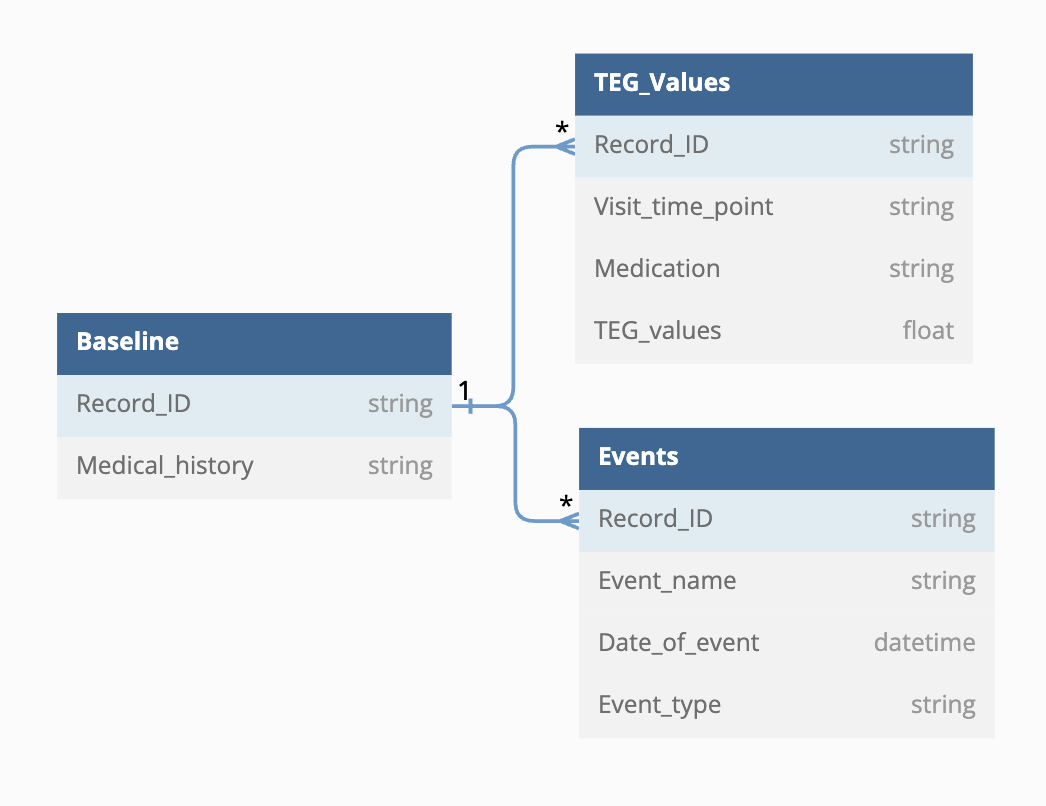

In [302]:
# Path to image
image_path = "./data/data_structure.png"
# Display the image
display(Image(filename=image_path, width=300, height=200))


In [303]:
# Count the number of events for each 'Record_ID' in events_df
event_counts = events_df['Record ID'].value_counts().reset_index()
event_counts.columns = ['Record ID', 'Events']
event_counts

,Record ID,Events
0,71,6
1,49,5
2,155,5
3,82,5
4,174,5
5,77,4
6,115,4
7,46,4
8,192,4
9,T21-41,4


In [304]:
# Merge the event counts with the baseline and teg values
tegValues_df = tegValues_df.merge(event_counts, on='Record ID', how='left')
baseline_df = baseline_df.merge(event_counts, on='Record ID', how='left')

# Fill NaN values in the 'event_count' column with 0
tegValues_df['Events'].fillna(0, inplace=True)
baseline_df['Events'].fillna(0, inplace=True)
tegValues_df.head()

,Record ID,Visit Timepoint,Antiplatelet Therapy within 7 Days,Anticoagulation within 24 Hours,Statin within 24 Hours,Cilostazol within 7 days,Reaction Time (R) in min,Lysis at 30 min (LY30) in %,CRT Max amplitude (MA) in mm,CFF Max Amplitude( MA) in mm,...,INR value,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL),BP prior to blood draw,Events
0,39,Baseline,"aspirin, ticagrelor",enoxaparin (Lovenox),Rosuvastatin,cilostazol,14.02407,1.268491,63.780276,37.48071,...,151.757216,121.451182,6.723782,12.394838,4.334694,10.318403,47.959012,155.287685,160/95,3.0
1,174,Post Op day 1 (4-36 hours),"clopidogrel, celecoxib",enoxaparin (Lovenox),Simvastatin,cilostazol,3.319251,1.449484,71.128769,26.758913,...,54.147810,86.95418,13.928991,14.034414,2.288993,8.347336,42.414855,414.026181,243/49,5.0
2,T21-58,Post Op day 1 (4-36 hours),ticagrelor,warfarin (Coumadin),Lovastatin,cilostazol,8.031243,6.83865,54.706969,18.961554,...,126.072895,124.331267,18.480140,13.002132,3.189830,15.962208,50.267115,495.118409,185/50,4.0
3,155,6hr Post,"aspirin, ticagrelor",rivaroxaban,Rosuvastatin,cilostazol,11.993521,inconclusive,71.450849,25.628047,...,22.585294,91.085144,7.809423,20.652979,5.963962,16.206970,50.746414,506.230494,128/136,5.0
4,47,PO Day 2,"aspirin, ticagrelor",enoxaprin,atorvastatin,cilostazol,16.477918,10.810169,inconclusive machine error,49.885941,...,98.907343,430,23.795725,24.328577,2.720811,9.905265,47.706937,139.320557,226/94,2.0


In [305]:
baseline_df.head()

,Record ID,Age,Sex,White,Extremity,Artery affected,BMI,"Tobacco Use (1 current 2 former, 3 none)",Diabetes,Hypertension,...,Does the patient have a history of solid organ transplant?,EGFR (mL/min/1.73m2),Has subject had previous intervention of the index limb?,Previous occluded stents,Rutherford Score,ABI Right,ABI left,Intervention Classification,Intervention Type,Events
0,39,81,Male,1,left,"common femoral, SFA, popliteal, anterior tibia...",40.373643,current within the last year ( < 1 pack a day),1,0,...,No,22.03354,Yes,0,4.717162,0.859011,0.104522,Open,angioplasty,3.0
1,174,70,Male,0,Bilateral,"common femoral, SFA, popliteal, posterior tibi...",15.619750,current within the last year ( > or = 1 pack ...,0,1,...,No,>60,0,0,3.561872,0.809203,0.916329,Open,bypass revision,5.0
2,T21-58,88,Male,1,left,common femoral,37.470921,quit 1 to 10 years ago,1,0,...,Yes,22.006291,No,0,3.659894,1.240163,0.13404,Endo,"angioplasty, stent, endarterectomy",4.0
3,155,78,Male,0,right,"SFA, anterior tibial, posterior tibial, extern...",15.888214,quit 1 to 10 years ago,0,0,...,No,6.906499,Yes,Yes,3.525905,0.760655,inaudible,Endo,"angioplasty, bypass",5.0
4,47,84,Female,0,right,"SFA, external iliac",31.979733,"Past, quit >10 year ago",1,1,...,Yes,11.809767,0,0,1.663111,0.329114,0.244715,Open,bypass revision,2.0


In [306]:
# Save in excel
excel_file = "./testData/merged_data.xlsx"

# Create an Excel writer object
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each DataFrame to a different Excel sheet
    tegValues_df.to_excel(writer, sheet_name='TEG values', index=False)
    baseline_df.to_excel(writer, sheet_name='Baseline', index=False)



### Data transformations
All columns are being transformed to the best fitting format, according to the information they hold and effectively removing any typos.

In [307]:
# Clean df in new copy
clean_TEG_df = tegValues_df.copy()
clean_baseline_df = baseline_df.copy()

#### Number
Baseline:
- Age
- BMI
- Clotting Disorder
- EGFR (mL/min/1.73m2)
- BP prior to blood draw
- ABI Right
- ABI Left
- Rutherford Score

TEG:
- TEG values
- Visit Timepoint


In [308]:
# Find teg values column
columns_to_exclude = ['Record ID', 'Visit Timepoint', 'Antiplatelet Therapy within 7 Days',
                      'Anticoagulation within 24 Hours', 'Statin within 24 Hours', 'Cilostazol within 7 days',
                      'BP prior to blood draw', 'Events']

tegValues = [col for col in tegValues_df.columns.values if col not in columns_to_exclude]
tegValues

['Reaction Time (R) in min',
 'Lysis at 30 min (LY30) in %',
 'CRT Max amplitude (MA) in mm',
 'CFF Max Amplitude( MA) in mm',
 'HKH MA (mm)',
 'ActF MA (mm)',
 'ADP MA (mm)',
 'AA MA(mm)',
 'ADP % Aggregation',
 'ADP % Inhibition',
 'AA % Aggregation',
 'AA % Inhibition',
 'CK R(min)',
 'CK K (min)',
 'CK angle( deg)',
 'CK MA (mm)',
 'CRT MA(mm)',
 'CKH R (min)',
 'CFF MA(mm)',
 'CFF FLEV(mg/dL)',
 'HbA1c Baseline( within1 year of study start)',
 'INR value',
 'aPTT',
 'PT value',
 'WBC in K/uL',
 'RBC (M/uL)',
 'HGB(g/dL)',
 'HCT %',
 'PLT(K/uL)']

In [309]:
number_columns_baseline = ["Age","BMI", "Clotting Disorder", "EGFR (mL/min/1.73m2)", "ABI Right", "ABI left", "Rutherford Score"]
number_columns_teg = ["Visit Timepoint", "BP prior to blood draw"]+tegValues

Visualize the values and their types to identify the kind of changes needed

In [310]:
clean_TEG_df[number_columns_teg].dtypes


Visit Timepoint                                  object
BP prior to blood draw                           object
Reaction Time (R) in min                         object
Lysis at 30 min (LY30) in %                      object
CRT Max amplitude (MA) in mm                     object
CFF Max Amplitude( MA) in mm                     object
HKH MA (mm)                                      object
ActF MA (mm)                                     object
ADP MA (mm)                                      object
AA MA(mm)                                        object
ADP % Aggregation                                object
ADP % Inhibition                                 object
AA % Aggregation                                 object
AA % Inhibition                                  object
CK R(min)                                        object
CK K (min)                                       object
CK angle( deg)                                   object
CK MA (mm)                                      

In [311]:
clean_baseline_df[number_columns_baseline].dtypes

Age                       int64
BMI                     float64
Clotting Disorder         int64
EGFR (mL/min/1.73m2)     object
ABI Right                object
ABI left                 object
Rutherford Score         object
dtype: object

Visualize the values 

In [312]:
clean_TEG_df[number_columns_teg].head()

,Visit Timepoint,BP prior to blood draw,Reaction Time (R) in min,Lysis at 30 min (LY30) in %,CRT Max amplitude (MA) in mm,CFF Max Amplitude( MA) in mm,HKH MA (mm),ActF MA (mm),ADP MA (mm),AA MA(mm),...,CFF FLEV(mg/dL),HbA1c Baseline( within1 year of study start),INR value,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL)
0,Baseline,160/95,14.02407,1.268491,63.780276,37.48071,60.551078,4.005524,33.115271,66.890611,...,1150.210716,5.764743,151.757216,121.451182,6.723782,12.394838,4.334694,10.318403,47.959012,155.287685
1,Post Op day 1 (4-36 hours),243/49,3.319251,1.449484,71.128769,26.758913,11.638807,>30.0,48.117204,28.182542,...,911.256002,8.267349,54.147810,86.95418,13.928991,14.034414,2.288993,8.347336,42.414855,414.026181
2,Post Op day 1 (4-36 hours),185/50,8.031243,6.83865,54.706969,18.961554,34.369101,2.900351,38.127375,83.103689,...,503.002443,5.195084,126.072895,124.331267,18.480140,13.002132,3.189830,15.962208,50.267115,495.118409
3,6hr Post,128/136,11.993521,inconclusive,71.450849,25.628047,24.09067,12.91638,<10.0,29.07214,...,476/3,6.679559,22.585294,91.085144,7.809423,20.652979,5.963962,16.206970,50.746414,506.230494
4,PO Day 2,226/94,16.477918,10.810169,inconclusive machine error,49.885941,25.960299,6.511959,"41,2",21.926659,...,1144.458966,8.529165,98.907343,430,23.795725,24.328577,2.720811,9.905265,47.706937,139.320557


In [313]:
clean_baseline_df[number_columns_baseline].head()

,Age,BMI,Clotting Disorder,EGFR (mL/min/1.73m2),ABI Right,ABI left,Rutherford Score
0,81,40.373643,2,22.03354,0.859011,0.104522,4.717162
1,70,15.619750,2,>60,0.809203,0.916329,3.561872
2,88,37.470921,1,22.006291,1.240163,0.13404,3.659894
3,78,15.888214,0,6.906499,0.760655,inaudible,3.525905
4,84,31.979733,1,11.809767,0.329114,0.244715,1.663111


Out of the columns visuzlied, age, BMI and clotting dissorder are in the right format.

BP needs to be split between systolic and diastolic and made into ints.

EGFR is a combination of strings and floats. The string is ">60", which can be approximated to a big number, like 65. All the other values are floats.
TEG values need to be transformed to floats. Some teg values have maximum value stored as ">n", or say "inconclusive" or other string when data was not colected. Those vaues wil be marked as nan
Both TEG values and EGFR boundary conditions are saved in the "./data_boundary.json" file

Visit timepoint is in strings and need to be based on days

ABI left and right have some strings that will be converted to NaN values

Split BP into two columns (systolic and diastolic) based on "/" 

In [314]:
# Split the column into 'Systolic' and 'Diastolic' columns
clean_TEG_df[['BP_Systolic', 'BP_Diastolic']] = clean_TEG_df['BP prior to blood draw'].str.split('/', expand=True)

# Convert 'Systolic' and 'Diastolic' columns to integers
clean_TEG_df['BP_Systolic'] = pd.to_numeric(clean_TEG_df['BP_Systolic'], errors='coerce').astype('Int64')
clean_TEG_df['BP_Diastolic'] = pd.to_numeric(clean_TEG_df['BP_Diastolic'], errors='coerce').astype('Int64')

# Drop the first column 'BP prior to blood draw'
clean_TEG_df.drop(columns=['BP prior to blood draw'], inplace = True)
number_columns_teg.remove('BP prior to blood draw')
number_columns_teg.append('BP_Systolic')
number_columns_teg.append('BP_Diastolic')

clean_TEG_df[['BP_Systolic', 'BP_Diastolic']].dtypes


BP_Systolic     Int64
BP_Diastolic    Int64
dtype: object

Clean EGFR and TEG data with boundary values and convert all to floats

In [315]:
# Import boundary values

# Get the current working directory (base directory)
base_directory = os.getcwd()

# Define the filename
filename = 'data_boundaries.json'

# Create the full file path by joining the base directory and filename
file_path = os.path.join(base_directory, 'data', filename)

with open(file_path, 'r') as json_file:
    boundaries = json.load(json_file)
boundaries

{'EGFR (mL/min/1.73m2)': {'>60': 60},
 'Reaction Time (R) in min': {'>17': 18},
 'HKH MA (mm)': {'<42': 40, '>71': 75},
 'ActF MA (mm)': {'>30': 35, '<2': 0},
 'ADP MA (mm)': {'<10': 5, '>72': 77},
 'AA MA(mm)': {'<8': 5},
 'CK R(min)': {'>17': 20},
 'CK K (min)': {'<': '>', '>5': 8},
 'CK angle( deg)': {'<39': 35},
 'CK MA (mm)': {'<40': 35, '>75': 80},
 'CRT MA(mm)': {'<40': 35, '>75': 80},
 'CRT Max amplitude (MA) in mm': {'<40': 35, '>75': 80},
 'CKH R (min)': {'>17': 20},
 'CFF MA(mm)': {'>52': 55, '<4': 0},
 'CFF Max Amplitude( MA) in mm': {'>52': 55, '<4': 0},
 'aPTT': {'>150': 160}}

In [316]:
# Replace all boundary values with their correcponding right values

# EGFR
egfr_column = 'EGFR (mL/min/1.73m2)'
efgr_replacement = boundaries.pop(egfr_column, None)
# Remove spaces in the column
clean_baseline_df[egfr_column] = clean_baseline_df[egfr_column].replace(regex={r'\s': ''})

# Use a regular expression to match and replace values
for name, replacement in efgr_replacement.items():
    clean_baseline_df[egfr_column] = clean_baseline_df[egfr_column].replace({f'^{name}': replacement}, regex=True)

# Iterate over TEG DataFrame and apply boundaries
for column, replacement_dict in boundaries.items():
    
    # Remove spaces in the column
    clean_TEG_df[column] = clean_TEG_df[column].replace(regex={r'\s': ''})
    
    # Use a regular expression to match and replace values
    for name, replacement in replacement_dict.items():
        clean_TEG_df[column] = clean_TEG_df[column].replace({f'^{name}': replacement}, regex=True)

# Show changes    
clean_TEG_df[list(boundaries.keys())].head()

,Reaction Time (R) in min,HKH MA (mm),ActF MA (mm),ADP MA (mm),AA MA(mm),CK R(min),CK K (min),CK angle( deg),CK MA (mm),CRT MA(mm),CRT Max amplitude (MA) in mm,CKH R (min),CFF MA(mm),CFF Max Amplitude( MA) in mm,aPTT
0,14.02407,60.551078,4.005524,33.115271,66.890611,530.964454,2.74555,35,35,65.81586,63.780276,31.275554,8.07024,37.48071,121.451182
1,3.319251,11.638807,35,48.117204,28.182542,372.62224,3.262636,54.664768,23.262281,50.963654,71.128769,22.664393,21.015413,26.758913,86.95418
2,8.031243,34.369101,2.900351,38.127375,83.103689,inconclusive,3.689334,72.802085,43.586144,85.057179,54.706969,2.36893,44.863261,18.961554,124.331267
3,11.993521,24.09067,12.91638,5,29.07214,542.831464,3.553863,35,notavailable,79.124757,71.450849,5.514348,34.688881,25.628047,91.085144
4,16.477918,25.960299,6.511959,"41,2",21.926659,29.84655,13.679995,53.155152,45.6435,59.05018,inconclusivemachineerror,28.279901,40.481286,49.885941,430


In [317]:
# Show changes
clean_baseline_df[egfr_column].head()

0    22.033540
1    60.000000
2    22.006291
3     6.906499
4    11.809767
Name: EGFR (mL/min/1.73m2), dtype: float64

In [318]:
# Convert  Rutherford Score and TEG values to float
clean_baseline_df["Rutherford Score"] = pd.to_numeric(clean_baseline_df["Rutherford Score"], errors='coerce')
clean_baseline_df["Rutherford Score"].dtypes


dtype('float64')

In [319]:
# Loop through the columns and convert to numeric
for column in tegValues:
    clean_TEG_df[column] = pd.to_numeric(clean_TEG_df[column], errors='coerce')

clean_TEG_df[tegValues].dtypes

Reaction Time (R) in min                        float64
Lysis at 30 min (LY30) in %                     float64
CRT Max amplitude (MA) in mm                    float64
CFF Max Amplitude( MA) in mm                    float64
HKH MA (mm)                                     float64
ActF MA (mm)                                    float64
ADP MA (mm)                                     float64
AA MA(mm)                                       float64
ADP % Aggregation                               float64
ADP % Inhibition                                float64
AA % Aggregation                                float64
AA % Inhibition                                 float64
CK R(min)                                       float64
CK K (min)                                      float64
CK angle( deg)                                  float64
CK MA (mm)                                      float64
CRT MA(mm)                                      float64
CKH R (min)                                     

In [320]:
# Show values to make sure strings were changed to NaN
clean_TEG_df[tegValues].head()

,Reaction Time (R) in min,Lysis at 30 min (LY30) in %,CRT Max amplitude (MA) in mm,CFF Max Amplitude( MA) in mm,HKH MA (mm),ActF MA (mm),ADP MA (mm),AA MA(mm),ADP % Aggregation,ADP % Inhibition,...,CFF FLEV(mg/dL),HbA1c Baseline( within1 year of study start),INR value,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL)
0,14.024070,1.268491,63.780276,37.480710,60.551078,4.005524,33.115271,66.890611,7.101021,24.874173,...,1150.210716,5.764743,151.757216,121.451182,6.723782,12.394838,4.334694,10.318403,47.959012,155.287685
1,3.319251,1.449484,71.128769,26.758913,11.638807,35.000000,48.117204,28.182542,74.891506,24.730532,...,911.256002,8.267349,54.147810,86.954180,13.928991,14.034414,2.288993,8.347336,42.414855,414.026181
2,8.031243,6.838650,54.706969,18.961554,34.369101,2.900351,38.127375,83.103689,54.041213,4.576856,...,503.002443,5.195084,126.072895,124.331267,18.480140,13.002132,3.189830,15.962208,50.267115,495.118409
3,11.993521,NaN,71.450849,25.628047,24.090670,12.916380,5.000000,29.072140,34.836606,NaN,...,NaN,6.679559,22.585294,91.085144,7.809423,20.652979,5.963962,16.206970,50.746414,506.230494
4,16.477918,10.810169,NaN,49.885941,25.960299,6.511959,NaN,21.926659,3.955611,49.750429,...,1144.458966,8.529165,98.907343,430.000000,23.795725,24.328577,2.720811,9.905265,47.706937,139.320557


Change timepoints from strings to ints that represent days after the operation.

All the values are saved in ./data/timepoints.json

In [321]:
# Define the filename
filename = 'timepoints.json'

# Create the full file path by joining the base directory and filename
file_path = os.path.join(base_directory, 'data', filename)


with open(file_path, 'r') as json_file:
    timepoints = json.load(json_file)
timepoints

{'0': ['Baseline', 'Enrollment + Baseline'],
 '1': ['6hr Post', 'PO Day 1 ( 4-36 hours)', 'Post Op day 1 (4-36 hours)'],
 '2': ['PO Day 2', 'Post op Day 2( if applicable)'],
 '3': ['PO Day 3', 'Post Op Day 3( if applicable)'],
 '4': ['PO Day 4', 'Post Op Day 4 ( if applicable)'],
 '5': ['PO day 5', 'Post Op Day 5 ( if applicable)'],
 '30': ['1M PO', '30 Day Post Procedure'],
 '90': ['3M PO', '3 Month Post procedure'],
 '180': ['6M PO', '6 month Post Procedure', 'Readmission']}

In [322]:
# Create a reverse mapping dictionary
reverse_mapping = {v: k for k, values in timepoints.items() for v in values}

# Replace values using the reverse mapping
clean_TEG_df['Days from operation'] = clean_TEG_df['Visit Timepoint'].map(reverse_mapping)

# Convert the column to integer
clean_TEG_df['Days from operation'] = clean_TEG_df['Days from operation'].astype(int)

# Drop old column
clean_TEG_df.drop(columns=['Visit Timepoint'], inplace = True)
number_columns_teg.remove('Visit Timepoint')
number_columns_teg.append('Days from operation')


In [323]:
clean_TEG_df['Days from operation'].dtype

dtype('int64')

Convert ABI values to floats

In [324]:
clean_baseline_df['ABI Right'] = pd.to_numeric(clean_baseline_df['ABI Right'], errors='coerce')
clean_baseline_df['ABI left'] = pd.to_numeric(clean_baseline_df['ABI left'], errors='coerce')

clean_baseline_df[['ABI Right', 'ABI left']].dtypes

ABI Right    float64
ABI left     float64
dtype: object

Appreciate all your work

In [325]:
clean_baseline_df[number_columns_baseline].head()

,Age,BMI,Clotting Disorder,EGFR (mL/min/1.73m2),ABI Right,ABI left,Rutherford Score
0,81,40.373643,2,22.033540,0.859011,0.104522,4.717162
1,70,15.619750,2,60.000000,0.809203,0.916329,3.561872
2,88,37.470921,1,22.006291,1.240163,0.134040,3.659894
3,78,15.888214,0,6.906499,0.760655,NaN,3.525905
4,84,31.979733,1,11.809767,0.329114,0.244715,1.663111


In [326]:
clean_TEG_df[number_columns_teg].head()

,Reaction Time (R) in min,Lysis at 30 min (LY30) in %,CRT Max amplitude (MA) in mm,CFF Max Amplitude( MA) in mm,HKH MA (mm),ActF MA (mm),ADP MA (mm),AA MA(mm),ADP % Aggregation,ADP % Inhibition,...,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL),BP_Systolic,BP_Diastolic,Days from operation
0,14.024070,1.268491,63.780276,37.480710,60.551078,4.005524,33.115271,66.890611,7.101021,24.874173,...,121.451182,6.723782,12.394838,4.334694,10.318403,47.959012,155.287685,160,95,0
1,3.319251,1.449484,71.128769,26.758913,11.638807,35.000000,48.117204,28.182542,74.891506,24.730532,...,86.954180,13.928991,14.034414,2.288993,8.347336,42.414855,414.026181,243,49,1
2,8.031243,6.838650,54.706969,18.961554,34.369101,2.900351,38.127375,83.103689,54.041213,4.576856,...,124.331267,18.480140,13.002132,3.189830,15.962208,50.267115,495.118409,185,50,1
3,11.993521,NaN,71.450849,25.628047,24.090670,12.916380,5.000000,29.072140,34.836606,NaN,...,91.085144,7.809423,20.652979,5.963962,16.206970,50.746414,506.230494,128,136,1
4,16.477918,10.810169,NaN,49.885941,25.960299,6.511959,NaN,21.926659,3.955611,49.750429,...,430.000000,23.795725,24.328577,2.720811,9.905265,47.706937,139.320557,226,94,2


#### Booleans
Baseline:
- Sex
- White
- Diabetes
- Hypertension
- Hyperlipidemia
- Coronary Artery Disease
- History of MI 
- Functional impairment
- Does Subject Currently have cancer?
- Past hx of cancer
- Hx of  DVT
- Hx of stroke
- Hx of pulmonary embolism:
- Does the patient have a history of solid organ transplant?
- Has subject had previous intervention of the index limb? 
- Previous occluded stents

TEG values:
- Cilostazol within 7 days

In [327]:
# Create the 'Is Male' column based on the 'sex' column
clean_baseline_df['Is Male'] = (clean_baseline_df['Sex'] == 'Male').astype(bool)

# Drop the old 'sex' column
clean_baseline_df.drop('Sex', axis=1, inplace=True)
clean_baseline_df['Is Male']

0      True
1      True
2      True
3      True
4     False
5      True
6     False
7     False
8      True
9      True
10     True
11     True
12    False
13    False
14     True
15    False
16    False
17     True
18    False
19     True
20     True
21    False
22     True
23     True
24    False
25    False
26    False
27     True
28    False
29    False
30    False
31     True
32     True
33    False
34    False
35    False
36    False
37     True
38     True
39    False
40     True
41     True
42    False
43    False
44    False
45    False
46    False
47     True
48    False
49    False
50     True
51    False
Name: Is Male, dtype: bool

In [328]:
# Change following columns to booleans
columns_to_convert_baseline = ['White', 'Diabetes', 'Hypertension', 'Hyperlipidemia (choice=None)', 'Coronary Artery Disease', 'History of MI',
                      'Functional impairment', 'Does Subject Currently have cancer?', 'Past hx of cancer', 'Hx of  DVT', 'Hx of stroke',
                      'Hx of pulmonary embolism', 'Does the patient have a history of solid organ transplant?', 
                      'Has subject had previous intervention of the index limb?', 'Previous occluded stents',]
columns_to_convert_TEG =['Cilostazol within 7 days']

clean_baseline_df[columns_to_convert_baseline].head()

,White,Diabetes,Hypertension,Hyperlipidemia (choice=None),Coronary Artery Disease,History of MI,Functional impairment,Does Subject Currently have cancer?,Past hx of cancer,Hx of DVT,Hx of stroke,Hx of pulmonary embolism,Does the patient have a history of solid organ transplant?,Has subject had previous intervention of the index limb?,Previous occluded stents
0,1,1,0,1,No,Yes,0,No,No,Yes,No,Yes,No,Yes,0
1,0,0,1,0,No,Yes,1,No,Yes,No,No,Yes,No,0,0
2,1,1,0,1,Yes,No,1,Yes,No,No,No,No,Yes,No,0
3,0,0,0,1,Yes,No,0,No,Yes,No,Yes,Yes,No,Yes,Yes
4,0,1,1,1,Yes,Yes,0,Yes,No,Yes,No,No,Yes,0,0


In [329]:
clean_TEG_df[columns_to_convert_TEG].head()

,Cilostazol within 7 days
0,cilostazol
1,cilostazol
2,cilostazol
3,cilostazol
4,cilostazol


In [330]:
# Dictionary for replacement
replacement_dict = {'yes': True, 'no': False, '1': True, '0': False, 'cilostazol': True, 'NaN':False}

In [331]:
# Fill NaN values with False
clean_baseline_df[columns_to_convert_baseline] = clean_baseline_df[columns_to_convert_baseline].fillna('0')
clean_TEG_df[columns_to_convert_TEG] = clean_TEG_df[columns_to_convert_TEG].fillna('0')

# Put all columns in lowercase
clean_baseline_df[columns_to_convert_baseline] = clean_baseline_df[columns_to_convert_baseline].astype(str)
clean_baseline_df[columns_to_convert_baseline] = clean_baseline_df[columns_to_convert_baseline].apply(lambda x: x.str.lower())
clean_TEG_df[columns_to_convert_TEG] = clean_TEG_df[columns_to_convert_TEG].astype(str)
clean_TEG_df[columns_to_convert_TEG] = clean_TEG_df[columns_to_convert_TEG].apply(lambda x: x.str.lower())

# Use the replace method to replace values in multiple columns
clean_baseline_df[columns_to_convert_baseline] = clean_baseline_df[columns_to_convert_baseline].replace(replacement_dict).astype(bool)
clean_TEG_df[columns_to_convert_TEG] = clean_TEG_df[columns_to_convert_TEG].replace(replacement_dict).astype(bool)

clean_baseline_df[columns_to_convert_baseline].head()


,White,Diabetes,Hypertension,Hyperlipidemia (choice=None),Coronary Artery Disease,History of MI,Functional impairment,Does Subject Currently have cancer?,Past hx of cancer,Hx of DVT,Hx of stroke,Hx of pulmonary embolism,Does the patient have a history of solid organ transplant?,Has subject had previous intervention of the index limb?,Previous occluded stents
0,True,True,False,True,False,True,False,False,False,True,False,True,False,True,False
1,False,False,True,False,False,True,True,False,True,False,False,True,False,False,False
2,True,True,False,True,True,False,True,True,False,False,False,False,True,False,False
3,False,False,False,True,True,False,False,False,True,False,True,True,False,True,True
4,False,True,True,True,True,True,False,True,False,True,False,False,True,False,False


In [332]:
clean_TEG_df[columns_to_convert_TEG].head()

,Cilostazol within 7 days
0,True
1,True
2,True
3,True
4,True


#### Categorical ordinal
Baseline:
- Tobacco Use
- Renal Status

In [333]:
# Ordinal encoding map
category_orders = {
    'Tobacco Use (1 current 2 former, 3 none)': 
    ['None',
    'Past, quit >10 year ago',
    'quit 1 to 10 years ago', 
    'current within the last year ( < 1 pack a day)',
    'current within the last year (  > or = 1 pack a day)'],

    'Renal Status': 
    ['Normal', 
    'GFR 30 to 59', 
    'GFR 15 to 29', 
    'GFR<15 or patient is on dialysis',
    '1']
}

In [334]:
# Replace renal status values. Some of the values in the data set mean the same with different words
# Define a dictionary to map old values to new values
replace_dict = {'GFR 60 to 89': 'Normal', 'Evidence of renal dysfunction ( GFR >90)': 'Normal', '0': 'Normal', 0: 'Normal', 1: "1"}

clean_baseline_df['Renal Status'] = clean_baseline_df['Renal Status'].replace(replace_dict)

# Initialize the OrdinalEncoder with specified category orders
encoder = OrdinalEncoder(categories=[category_orders[column] for column in ['Tobacco Use (1 current 2 former, 3 none)', 'Renal Status']])

# Fit and transform the selected columns to encode ordinal values
clean_baseline_df[['Tobacco Use (1 current 2 former, 3 none)', 'Renal Status']] = encoder.fit_transform(clean_baseline_df[['Tobacco Use (1 current 2 former, 3 none)', 'Renal Status']])

# Rename column
clean_baseline_df = clean_baseline_df.rename(columns={'Tobacco Use (1 current 2 former, 3 none)': 'Tobacco Use'})

In [335]:
clean_baseline_df[['Tobacco Use', 'Renal Status']].head()

,Tobacco Use,Renal Status
0,3.0,0.0
1,4.0,4.0
2,2.0,0.0
3,2.0,0.0
4,1.0,0.0


#### Categorical nominal
Baseline:
- Extremity
- Artery affected
- Intervention Classification
- Intervention Type

TEG values:
- Antiplatelet Therapy within 7 Days
- Anticoagulation within 24 Hours
- Statin within 24 Hours


In [336]:
columns_to_dummy_baseline = ['Extremity',
                    'Intervention Classification']
columns_to_dummy_TEG = ['Statin within 24 Hours']

In [337]:
# Dummy encoding of categorical values
clean_baseline_df = pd.get_dummies(clean_baseline_df, columns=columns_to_dummy_baseline,
                    prefix=columns_to_dummy_baseline)
clean_TEG_df = pd.get_dummies(clean_TEG_df, columns=columns_to_dummy_TEG,
                    prefix=columns_to_dummy_TEG)

In [338]:
# Drop unecessary columns
clean_baseline_df = clean_baseline_df.drop(columns=['Extremity_left']) # Because it is either right, left or bilateral
clean_baseline_df = clean_baseline_df.drop(columns=['Intervention Classification_Endo']) # Either endo, open or combined

In [339]:
# Show columns 
# Use the .filter() method to select columns with the original columns prefixes
dummy_columns_baseline = [col for col in clean_baseline_df.columns if any(col.startswith(prefix) for prefix in columns_to_dummy_baseline)]
clean_baseline_df[dummy_columns_baseline].head()

,Extremity_Bilateral,Extremity_right,Intervention Classification_Combined,Intervention Classification_Open
0,False,False,False,True
1,True,False,False,True
2,False,False,False,False
3,False,True,False,False
4,False,True,False,True


In [340]:
dummy_columns_TEG = [col for col in clean_TEG_df.columns if any(col.startswith(prefix) for prefix in columns_to_dummy_TEG)]
clean_TEG_df[dummy_columns_TEG].head()

,Statin within 24 Hours_Lovastatin,Statin within 24 Hours_Pravastatin,Statin within 24 Hours_Rosuvastatin,Statin within 24 Hours_Simvastatin,Statin within 24 Hours_atorvastatin
0,False,False,True,False,False
1,False,False,False,True,False
2,True,False,False,False,False
3,False,False,True,False,False
4,False,False,False,False,True


The _Artery affected_, _Intervention type_, _Antiplatelet Therapy within 7 Days_, and _Anticoagulation within 24 Hours_ column has multiple values in a sigle string. They will be normalized before being encoded

Artery affected

In [341]:
# Get all unique valuses
unique_arteries = set()
unique_antiplatelet = set()
unique_intervention = set()
unique_anticoagulation = set()

for index, row in clean_baseline_df.iterrows():
    # Check if the value is a string before splitting
    if isinstance(row['Artery affected'], str):
        arteries = row['Artery affected'].split(', ')
        unique_arteries.update(arteries)

    # Check if the value is a string before splitting
    if isinstance(row['Intervention Type'], str):
        intervention = row['Intervention Type'].split(', ')
        unique_intervention.update(intervention)
    

for index, row in clean_TEG_df.iterrows():
    # Check if the value is a string and not NaN before splitting
    if isinstance(row['Antiplatelet Therapy within 7 Days'], str):
        antiplatelet = row['Antiplatelet Therapy within 7 Days'].split(', ')
        unique_antiplatelet.update(antiplatelet)

    # Check if the value is a string and not NaN before splitting
    if isinstance(row['Anticoagulation within 24 Hours'], str):
        anticoagulation = row['Anticoagulation within 24 Hours'].split(', ')
        # Delete items in parenthesis ex: heparin (Calciparine) to be just heparin
        anticoagulation = {re.sub(r'\s*\([^)]*\)\s*', '', item) for item in anticoagulation}
        unique_anticoagulation.update(anticoagulation)


print(unique_arteries)
print(unique_antiplatelet)
print(unique_intervention)
print(unique_anticoagulation)

{'SFA', 'popliteal', 'anterior tibial', 'aortoiliac', 'internal iliac', 'posterior tibial', 'common femoral', 'external iliac'}
{'ticagrelor', 'celecoxib', 'clopidogrel', 'aspirin'}
{'bypass', 'endarterectomy', 'bypass revision', 'DVA', 'stent', 'thrombectomy', 'angioplasty'}
{'enoxaprin', 'heparin', 'warfarin', 'enoxaparin', 'apixaban', 'rivaroxaban'}


In [342]:
# Dummy encode arteries affected

# Fill NaN values with 0 in the 'Artery affected' column
clean_baseline_df['Artery affected'].fillna(0, inplace=True)

selected_arteries = []
for artery in unique_arteries:
    column_name = "Artery affected_" + artery
    # Convert to int after filling NaN with 0
    clean_baseline_df[column_name] = clean_baseline_df['Artery affected'].str.contains(artery).fillna(0).astype(int)
    selected_arteries.append(column_name)

selected_arteries.append('Artery affected')

clean_baseline_df[selected_arteries].head()

,Artery affected_SFA,Artery affected_popliteal,Artery affected_anterior tibial,Artery affected_aortoiliac,Artery affected_internal iliac,Artery affected_posterior tibial,Artery affected_common femoral,Artery affected_external iliac,Artery affected
0,1,1,1,1,0,1,1,0,"common femoral, SFA, popliteal, anterior tibia..."
1,1,1,0,0,1,1,1,1,"common femoral, SFA, popliteal, posterior tibi..."
2,0,0,0,0,0,0,1,0,common femoral
3,1,0,1,0,0,1,0,1,"SFA, anterior tibial, posterior tibial, extern..."
4,1,0,0,0,0,0,0,1,"SFA, external iliac"


In [343]:
# Dummy encode antiplatelet therapy

# Fill NaN values with 0 in the 'Antiplatelet Therapy within 7 Days' column
clean_TEG_df['Antiplatelet Therapy within 7 Days'].fillna(0, inplace=True)


selected_antiplatelet = []
for antiplatelet in unique_antiplatelet:
    column_name = "Antiplatelet therapy_" + antiplatelet

    # Handle NaN values and convert to int
    clean_TEG_df[column_name] = clean_TEG_df['Antiplatelet Therapy within 7 Days'].apply(lambda x: 1 if antiplatelet in str(x) else 0).astype(int)

    selected_antiplatelet.append(column_name)

selected_antiplatelet.append('Antiplatelet Therapy within 7 Days')


clean_TEG_df[selected_antiplatelet].head()

,Antiplatelet therapy_ticagrelor,Antiplatelet therapy_celecoxib,Antiplatelet therapy_clopidogrel,Antiplatelet therapy_aspirin,Antiplatelet Therapy within 7 Days
0,1,0,0,1,"aspirin, ticagrelor"
1,0,1,1,0,"clopidogrel, celecoxib"
2,1,0,0,0,ticagrelor
3,1,0,0,1,"aspirin, ticagrelor"
4,1,0,0,1,"aspirin, ticagrelor"


In [344]:
# Dummy encode intervention types

# Fill NaN values with an empty string in the 'Intervention Type' column
clean_baseline_df['Intervention Type'].fillna('', inplace=True)

selected_intervention = []
for intervention in unique_intervention:
    column_name = 'Intervention type_' + intervention

    # Handle NaN values and convert to int
    clean_baseline_df[column_name] = clean_baseline_df['Intervention Type'].apply(lambda x: 1 if intervention in str(x) else 0).astype(int)

    selected_intervention.append(column_name)


selected_intervention.append('Intervention Type')

clean_baseline_df[selected_intervention].head()

,Intervention type_bypass,Intervention type_endarterectomy,Intervention type_bypass revision,Intervention type_DVA,Intervention type_stent,Intervention type_thrombectomy,Intervention type_angioplasty,Intervention Type
0,0,0,0,0,0,0,1,angioplasty
1,1,0,1,0,0,0,0,bypass revision
2,0,1,0,0,1,0,1,"angioplasty, stent, endarterectomy"
3,1,0,0,0,0,0,1,"angioplasty, bypass"
4,1,0,1,0,0,0,0,bypass revision


In [345]:
# Dummy encode anticoagulation meds

# Fill NaN values with an empty string in the 'Anticoagulation within 24 Hours' column
clean_TEG_df['Anticoagulation within 24 Hours'].fillna('', inplace=True)

selected_anticoagulation = []
for anticoagulation in unique_anticoagulation:
    column_name = "Anticoagulation_" + anticoagulation

    # Handle NaN values and convert to int
    clean_TEG_df[column_name] = clean_TEG_df['Anticoagulation within 24 Hours'].apply(lambda x: 1 if anticoagulation in str(x) else 0).astype(int)

    selected_anticoagulation.append(column_name)

selected_anticoagulation.append('Anticoagulation within 24 Hours')

clean_TEG_df[selected_anticoagulation].head()

,Anticoagulation_enoxaprin,Anticoagulation_heparin,Anticoagulation_warfarin,Anticoagulation_enoxaparin,Anticoagulation_apixaban,Anticoagulation_rivaroxaban,Anticoagulation within 24 Hours
0,0,0,0,1,0,0,enoxaparin (Lovenox)
1,0,0,0,1,0,0,enoxaparin (Lovenox)
2,0,0,1,0,0,0,warfarin (Coumadin)
3,0,0,0,0,0,1,rivaroxaban
4,1,0,0,0,0,0,enoxaprin


In [346]:
# Drop old columns
clean_baseline_df.drop(columns=['Artery affected','Intervention Type'], inplace=True)
clean_TEG_df.drop(columns=['Antiplatelet Therapy within 7 Days', 'Anticoagulation within 24 Hours'], inplace=True)

In [347]:
# Save in excel
excel_file = "./testData/clean_data.xlsx"

# Create an Excel writer object
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Write each DataFrame to a different Excel sheet
    clean_TEG_df.to_excel(writer, sheet_name='TEG values', index=False)
    clean_baseline_df.to_excel(writer, sheet_name='Baseline', index=False)


## Extend data
Create the rate of change of teg values colum

In [348]:
# User selects to extend data
user_extend_data = False

In [349]:
# Columns
tegValues

['Reaction Time (R) in min',
 'Lysis at 30 min (LY30) in %',
 'CRT Max amplitude (MA) in mm',
 'CFF Max Amplitude( MA) in mm',
 'HKH MA (mm)',
 'ActF MA (mm)',
 'ADP MA (mm)',
 'AA MA(mm)',
 'ADP % Aggregation',
 'ADP % Inhibition',
 'AA % Aggregation',
 'AA % Inhibition',
 'CK R(min)',
 'CK K (min)',
 'CK angle( deg)',
 'CK MA (mm)',
 'CRT MA(mm)',
 'CKH R (min)',
 'CFF MA(mm)',
 'CFF FLEV(mg/dL)',
 'HbA1c Baseline( within1 year of study start)',
 'INR value',
 'aPTT',
 'PT value',
 'WBC in K/uL',
 'RBC (M/uL)',
 'HGB(g/dL)',
 'HCT %',
 'PLT(K/uL)']

In [350]:
extended_df = clean_TEG_df.copy()

In [351]:
if user_extend_data:    
    # Sort the DataFrame by "Record ID" and "Visit Timepoint"
    extended_df= extended_df.sort_values(by=["Record ID", "Days from operation"])
    extended_df[["Record ID", "Days from operation"]]

In [352]:
if user_extend_data:
    # Group by 'Record ID'
    grouped = extended_df.groupby('Record ID')

    #Calculate the difference in 'Days from operation'
    extended_df['Days Diff'] = grouped['Days from operation'].diff()

    # Replace 0s to avoid infinity
    extended_df["Days Diff"] = extended_df["Days Diff"].replace(0, 1)

    extended_df[["Record ID", "Days from operation", "Days Diff"]]


In [353]:
if user_extend_data:
    new_columns = []
    # Iterate TEG values
    for value in tegValues:

        # Get column names
        diff_column_name = f"{value}_difference_since_last_timepoint"
        rate_column_name = f"{value}_rate_since_last_timepoint"
        new_columns.append(diff_column_name)
        new_columns.append(rate_column_name)


        # Calculate the difference in TEG values
        extended_df[diff_column_name] = grouped[value].diff()

        # Divide  by the differences in 'Days from operation'
        extended_df[rate_column_name] = extended_df[diff_column_name] / extended_df['Days Diff']

    # Fill the first value with the next one to avoid NaN
    extended_df.bfill(inplace=True)

In [354]:
if user_extend_data:
    extended_df[new_columns]


In [355]:
if user_extend_data:
    # Drop column with diff in dates
    extended_df.drop(columns=["Days Diff"], inplace = True)

In [356]:
if user_extend_data:
    # Save in excel
    excel_file = "./testData/extended_data.xlsx"

    # Create an Excel writer object
    with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
        # Write each DataFrame to a different Excel sheet
        extended_df.to_excel(writer, sheet_name='TEG values', index=False)
        clean_baseline_df.to_excel(writer, sheet_name='Baseline', index=False)

## Data visualization
The goal of this section is to create the graphs that will be shown to the user describing the general data demographics
Some of the values are calculated based on the totaal number of patients in the baseline information, and some is calculated from the TEG values

Baseline summary:
- Age
- Gender
- Ethnicity
- BMI

TEG values:
- Number of events
- Total number of data points

In [357]:
fig_df = clean_baseline_df.copy()

In [358]:
# Define custom colors
male_colors = ['#d9ed92', '#99d98c'] 
white_colors = ['#184e77', '#1a759f'] 
events_colors = '#1a759f'
age_histogram_color = '#52b69a' 
bmi_histogram_color = '#1e6091'

In [359]:
# Count binary values in the "Male" column
male_counts = fig_df['Is Male'].value_counts()
male_labels = ['Male' if male_counts.index[0] else 'Female', 'Male' if not male_counts.index[0] else 'Female']
# Create a pie chart for "Male" with custom colors
sex_pie = go.Pie(labels=male_labels, values=male_counts, marker=dict(colors=male_colors))

# Visualize
data = [sex_pie]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

In [360]:
# Count binary values in the "White" column
white_counts = fig_df['White'].value_counts()
white_labels = ['White' if white_counts.index[0] else 'Non-White', 'White' if not white_counts.index[0] else 'Non-White']

# Create a pie chart for "White" with custom colors
white_pie = go.Pie(labels=white_labels, values=white_counts, marker=dict(colors=white_colors))

# Visualize
data = [white_pie]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

In [361]:
# BMI histogram
bmi_hist =  go.Histogram(x=fig_df["BMI"], name="BMI", marker=dict(color=bmi_histogram_color))

# Visualize
data = [bmi_hist]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

In [362]:
# Age histogram
age_hist=  go.Histogram(x=fig_df["Age"], name="Age", marker=dict(color=age_histogram_color))

# Visualize
data = [age_hist]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

The following metrics are bsed on the total number of TEG test values

In [363]:
# Copy TEG df to find metrics
fig_df = clean_TEG_df.copy()

In [364]:
# Events histogram 
events_hist =  go.Histogram(x=fig_df["Events"], name="Events", marker=dict(color=events_colors))

# Visualize
data = [events_hist]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

In [365]:
# Create a summary table
unique_patients = fig_df['Record ID'].nunique()
total_data_points = len(fig_df)

data_summary = pd.DataFrame({
    'Category': ['Unique Patients', 'Total Data Points'],
    'Count': [unique_patients, total_data_points]
})

patients_table = go.Table(
    header=dict(values=["Category", "Count"]),
    cells=dict(values=[data_summary['Category'], data_summary['Count']])
)

# Visualize
data = [patients_table]
fig = go.Figure(data = data)
fig.update_layout(width=300, height=300)
display(fig)

In [366]:
# Create subplots
fig = make_subplots(rows=2, cols=3,
                    specs=[[{'type':'domain'}, {'type':'domain'},{'type':'xy'}],
                            [{'type':'xy'}, {'type':'xy'},{'type':'domain'}]],
                    subplot_titles=['Gender Distribution', 'Ethnicity Distribution', 'Thrombotic event', 'BMI',
                                    'Age', 'Data Summary'])

fig.add_trace(sex_pie, row=1, col=1)
fig.add_trace(white_pie, row=1, col=2)
fig.add_trace(events_hist, row=1, col=3)
fig.add_trace(bmi_hist, row=2, col=1)
fig.add_trace(age_hist, row=2, col=2)
fig.add_trace(patients_table, row=2, col=3)

fig.update_layout(width=900, height=600)
display(fig)

## Train model function
There will be three models trained, so a function is being created now to be used multiple times.

In [367]:
def train_model(df, target_column, drop_columns, quantile_range=(5,95)):
    """
    Trains an XGBoost regression model on the given DataFrame using grid search for hyperparameter tuning.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the features and target variable.
    - target_column (str): The name of the target variable column.
    - drop_columns (list): List of column names to be dropped from the feature set.

    Returns:
    - best_pipeline (Pipeline): The best-performing pipeline after hyperparameter tuning.

    Example:
    best_model = train_model(df=my_dataframe, target_column='target', drop_columns=['column1', 'column2'])
    """

    # Separate features (X) and target (y)
    y = df[target_column]
    X = df.drop(labels=drop_columns + [target_column], axis=1)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create transformers for feature scaling
    target_scaler = RobustScaler(quantile_range=quantile_range)
   

    # Scale target
    # Fit the target scaler on training target and transform both training and test target
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


    # Create a pipeline
    pipeline = Pipeline([
        ('feature_scaler', RobustScaler()),  # Robust scaling for features
        ('xgb_regressor', XGBRegressor())    # XGBoost regressor
    ])

    # Define hyperparameter grid for tuning (adjust as needed)
    param_grid = {
        'xgb_regressor__max_depth': [3, 4, 5],
        'xgb_regressor__gamma': [0, 0.1, 0.2],
        'xgb_regressor__min_child_weight': [1, 2, 5]
    }

    # Initialize K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                               scoring='r2', cv=kf)

    # Fit the model and perform hyperparameter tuning
    grid_search.fit(X_train, y_train)

    
    # Access the best pipeline
    best_pipeline = grid_search.best_estimator_

    # Make predictions on the test data
    y_pred = best_pipeline.predict(X_test)  
    # Evaluate the model using Mean Squared Error
    mse_test = mean_squared_error(y_test, y_pred)
    # Calculate R-squared (R2) score
    r2_test = r2_score(y_test, y_pred)
    print(y_test, y_pred)

    # Make predictions on the train data
    y_pred = best_pipeline.predict(X_train)  
    # Evaluate the model using Mean Squared Error
    mse_train = mean_squared_error(y_train, y_pred)
    # Calculate R-squared (R2) score
    r2_train = r2_score(y_train, y_pred)
    print(y_train, y_pred)
    
    score = {"mse test":mse_test, "r2 test": r2_test, "mse train": mse_train, "r2 train": r2_train}

    return best_pipeline, X_train, score

## Shapeley value function
The shapeley value will be used in the models to determine the most important features. This is done multiple times so a function will be created

In [368]:
def feature_importance(best_pipeline, X):
    """
    Generate SHAP (SHapley Additive exPlanations) values and a summary plot for feature importance.

    Parameters:
    - best_pipeline (Pipeline): The best-performing pipeline after hyperparameter tuning. It should have an XGBoost regressor named 'xgb_regressor'.
    - X (pd.DataFrame): Data to be tested, containing features for which SHAP values will be computed.

    Returns:
    - importance_df (pd.DataFrame): DataFrame containing feature names and their importance values.
    - shap_values (numpy.ndarray): SHAP values for the provided data.

    Example:
    importance_df, shap_values = feature_importance(best_pipeline=my_best_pipeline, X=my_test_data)
    
    Note:
    The SHAP (SHapley Additive exPlanations) values provide insights into the contribution of each feature to model predictions. The summary plot and importance DataFrame help identify the most influential features.

    Dependencies:
    - Ensure the 'shap' library is installed. You can install it using 'pip install shap'.

    Usage:
    - For the best results, pass the best-performing pipeline obtained after hyperparameter tuning. The pipeline should include an XGBoost regressor with the name 'xgb_regressor'.

    """
    # Create a SHAP explainer for the XGBoost model
    explainer = shap.Explainer(best_pipeline.named_steps['xgb_regressor'])

    # Generate SHAP values
    shap_values = explainer.shap_values(X)

    # Calculate feature importance using the absolute mean of SHAP values
    feature_importance = np.abs(shap_values).mean(axis=0)

    # Create a DataFrame to associate feature names with their importance values
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

    # Sort the DataFrame by importance in descending order to find the most important features
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    return importance_df, shap_values

In [369]:
baseline_columns = list(clean_baseline_df.columns)

## Baseline Model
The first model will be used to the determine the risk of someone based on their baseline information

### Create model

In [370]:
best_model_baseline, baseline_train, baseline_score = train_model(clean_baseline_df, 'Events', ['Record ID'])

[ 0.   -0.25  0.    0.25  0.   -0.25 -0.25  0.    0.5   0.25 -0.5 ] [-0.13680118  0.0575355  -0.08962508 -0.09941888 -0.13680118  0.00270815
  0.08752407  0.11001087 -0.08293433 -0.21563046 -0.01599456]
[-0.5   0.    0.25  0.25 -0.25 -0.5   0.25  0.    0.75 -0.5   0.   -0.25
  0.25  0.    0.    0.5  -0.5   0.    0.25  0.25  0.25  0.5   0.   -0.25
  0.5   0.25  0.25 -0.25 -0.5  -0.25  0.25 -0.25 -0.5  -0.5  -0.25 -0.25
 -0.75  0.25  0.25 -0.25  0.  ] [-0.13680118 -0.01079584  0.11702623  0.03968013 -0.01599456 -0.31370455
  0.15014687  0.00270815  0.24798037 -0.27194783 -0.10215725 -0.07341858
  0.13883401  0.01139727 -0.07341858  0.15014687 -0.2020901   0.01139727
 -0.13044007  0.02519496  0.15614912  0.13921939  0.02519496 -0.20856519
  0.19628507  0.19628507  0.11580691 -0.21489955 -0.1522478  -0.03742778
  0.11702623 -0.01079584 -0.31370455 -0.37708718 -0.1522478  -0.08962508
 -0.37708718  0.21364044  0.1440897  -0.17295668 -0.01079584]


In [371]:
baseline_score

{'mse test': 0.11299137654972502,
 'r2 test': -0.5405021478892089,
 'mse train': 0.043973626085504085,
 'r2 train': 0.6320116219055016}

### Feauture importance
This information could be used for general information

In [372]:
importance_df_bsaeline, shap_values_baseline  = feature_importance(best_model_baseline, baseline_train)

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[15:53:26] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/ana

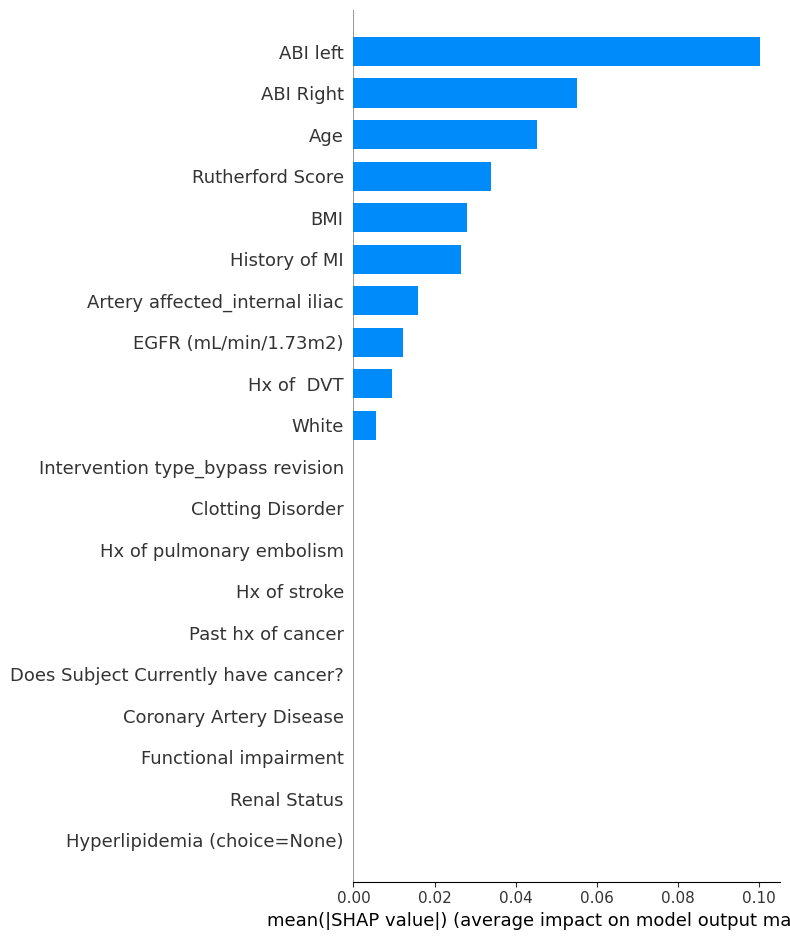

In [373]:
# Plot SHAP summary plot
shap.summary_plot(shap_values_baseline, baseline_train, plot_type="bar", show= False)

## TEG model 1
The first model will be used to determine the feature importance so the user can then select parameters of interest.

### Create model

In [374]:
teg1_columns =  list(extended_df.columns)

In [375]:
best_model_TEG1, TEG1_train, TEG1_score = train_model(extended_df, 'Events', ['Record ID'])

[-0.25  0.   -0.5  -0.5   0.25 -0.5   0.25 -0.5   0.25 -0.25 -0.5   0.
 -0.5   0.    0.    0.25  0.   -0.5   0.    0.25  0.25 -0.25  0.   -0.25
  0.25  0.    0.   -0.5  -0.5   0.   -0.75  0.    0.25  0.    0.5  -0.25
  0.25  0.25  0.25 -0.5  -0.5   0.25 -0.5  -0.5  -0.25 -0.25 -0.75  0.25
  0.25  0.25 -0.25 -0.25  0.25  0.25  0.25 -0.25  0.    0.25  0.25  0.25
 -0.5   0.    0.25  0.25 -0.25  0.25 -0.5  -0.75 -0.25  0.25  0.5   0.
  0.    0.75  0.25  0.    0.5  -0.5  -0.5   0.25  0.25  0.75 -0.25  0.5
  0.    0.5   0.25  0.   -0.5   0.   -0.25  0.5   0.25  0.   -0.25  0.
  0.    0.    0.25 -0.5  -0.25  0.25 -0.25  0.25  0.25  0.25 -0.25  0.
  0.    0.5  -0.25  0.    0.25 -0.25  0.    0.25  0.5  -0.5   0.5   0.25
 -0.25  0.25  0.25  0.    0.25  0.25  0.    0.    0.25  0.25  0.    0.
  0.    0.25  0.25  0.    0.    0.25 -0.25 -0.25  0.5   0.25  0.   -0.25
 -0.75  0.25 -0.5   0.25 -0.25 -0.25  0.25  0.25 -0.25  0.25 -0.25 -0.25
 -0.5   0.25 -0.25  0.25] [-0.11251313  0.03108146 -0.09782685

In [376]:
TEG1_score

{'mse test': 0.11993044631800982,
 'r2 test': -0.1505682354340514,
 'mse train': 0.04253761466657903,
 'r2 train': 0.6188355763945053}

### Feature importance

In [377]:
importance_df_TEG1, shap_values_TEG1 = feature_importance(best_model_TEG1, TEG1_train)

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[15:54:08] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/ana

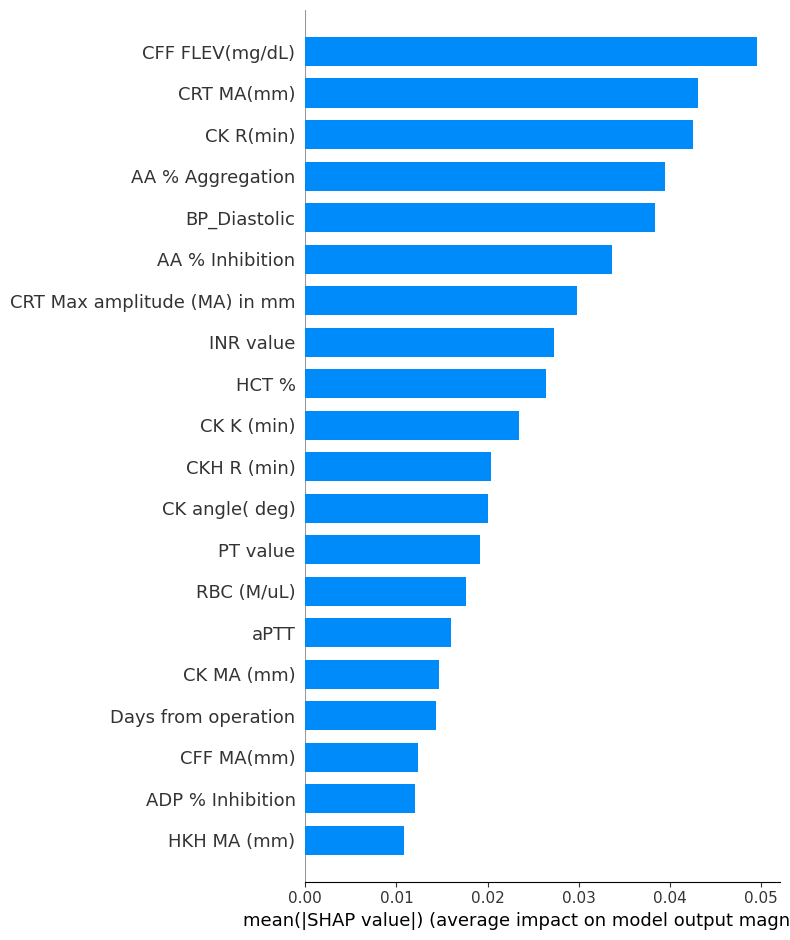

In [378]:
# Plot SHAP summary plot
shap.summary_plot(shap_values_TEG1, TEG1_train, plot_type="bar", show= False)

## User interface
Here , the user will select the features that they want to test in the next iteration of the model, based on the results from the first model.

Streamlit can read strings so for the sake of this notebook streamlit outputs will be printed strings

In [379]:
user_TEG_df = extended_df.copy()
user_TEG_df.head()

,Record ID,Cilostazol within 7 days,Reaction Time (R) in min,Lysis at 30 min (LY30) in %,CRT Max amplitude (MA) in mm,CFF Max Amplitude( MA) in mm,HKH MA (mm),ActF MA (mm),ADP MA (mm),AA MA(mm),...,Antiplatelet therapy_ticagrelor,Antiplatelet therapy_celecoxib,Antiplatelet therapy_clopidogrel,Antiplatelet therapy_aspirin,Anticoagulation_enoxaprin,Anticoagulation_heparin,Anticoagulation_warfarin,Anticoagulation_enoxaparin,Anticoagulation_apixaban,Anticoagulation_rivaroxaban
0,39,True,14.024070,1.268491,63.780276,37.480710,60.551078,4.005524,33.115271,66.890611,...,1,0,0,1,0,0,0,1,0,0
1,174,True,3.319251,1.449484,71.128769,26.758913,11.638807,35.000000,48.117204,28.182542,...,0,1,1,0,0,0,0,1,0,0
2,T21-58,True,8.031243,6.838650,54.706969,18.961554,34.369101,2.900351,38.127375,83.103689,...,1,0,0,0,0,0,1,0,0,0
3,155,True,11.993521,NaN,71.450849,25.628047,24.090670,12.916380,5.000000,29.072140,...,1,0,0,1,0,0,0,0,0,1
4,47,True,16.477918,10.810169,NaN,49.885941,25.960299,6.511959,NaN,21.926659,...,1,0,0,1,1,0,0,0,0,0


In [380]:
# Keep only the most important values from teg. No need for extra created ones
if user_extend_data:
    columns_to_keep = dict.fromkeys(user_TEG_df.columns.difference(tegValues + new_columns), None)
else:
    columns_to_keep = dict.fromkeys(user_TEG_df.columns.difference(tegValues), None)

# Iterate through prefixes and select the most important column for each
for prefix in tegValues:
    # Filter the importance_df_TEG1 for the current prefix
    prefix_columns = importance_df_TEG1[importance_df_TEG1['Feature'].str.startswith(prefix)]

    if not prefix_columns.empty:
        # Find the column with the maximum importance for the current prefix
        max_importance_row = prefix_columns.loc[prefix_columns['Importance'].idxmax()]

        # Check if the maximum importance value is greater than 0
        if max_importance_row['Importance'] > 0:
            max_importance_column = max_importance_row['Feature']
            columns_to_keep[max_importance_column] =max_importance_row['Importance']

        else:
            columns_to_keep[prefix] = 0

columns_to_keep


{'Anticoagulation_apixaban': None,
 'Anticoagulation_enoxaparin': None,
 'Anticoagulation_enoxaprin': None,
 'Anticoagulation_heparin': None,
 'Anticoagulation_rivaroxaban': None,
 'Anticoagulation_warfarin': None,
 'Antiplatelet therapy_aspirin': None,
 'Antiplatelet therapy_celecoxib': None,
 'Antiplatelet therapy_clopidogrel': None,
 'Antiplatelet therapy_ticagrelor': None,
 'BP_Diastolic': None,
 'BP_Systolic': None,
 'Cilostazol within 7 days': None,
 'Days from operation': None,
 'Events': None,
 'Record ID': None,
 'Statin within 24 Hours_Lovastatin': None,
 'Statin within 24 Hours_Pravastatin': None,
 'Statin within 24 Hours_Rosuvastatin': None,
 'Statin within 24 Hours_Simvastatin': None,
 'Statin within 24 Hours_atorvastatin': None,
 'Reaction Time (R) in min': 0.004997377,
 'Lysis at 30 min (LY30) in %': 0.009931776,
 'CRT Max amplitude (MA) in mm': 0.029802341,
 'CFF Max Amplitude( MA) in mm': 0.009514917,
 'HKH MA (mm)': 0.0108310385,
 'ActF MA (mm)': 0.003684532,
 'ADP MA

In [381]:
# Keep only non repeated values
user_TEG_df = user_TEG_df[columns_to_keep.keys()]
user_TEG_df.head()

,Anticoagulation_apixaban,Anticoagulation_enoxaparin,Anticoagulation_enoxaprin,Anticoagulation_heparin,Anticoagulation_rivaroxaban,Anticoagulation_warfarin,Antiplatelet therapy_aspirin,Antiplatelet therapy_celecoxib,Antiplatelet therapy_clopidogrel,Antiplatelet therapy_ticagrelor,...,CFF FLEV(mg/dL),HbA1c Baseline( within1 year of study start),INR value,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL)
0,0,1,0,0,0,0,1,0,0,1,...,1150.210716,5.764743,151.757216,121.451182,6.723782,12.394838,4.334694,10.318403,47.959012,155.287685
1,0,1,0,0,0,0,0,1,1,0,...,911.256002,8.267349,54.147810,86.954180,13.928991,14.034414,2.288993,8.347336,42.414855,414.026181
2,0,0,0,0,0,1,0,0,0,1,...,503.002443,5.195084,126.072895,124.331267,18.480140,13.002132,3.189830,15.962208,50.267115,495.118409
3,0,0,0,0,1,0,1,0,0,1,...,NaN,6.679559,22.585294,91.085144,7.809423,20.652979,5.963962,16.206970,50.746414,506.230494
4,0,0,1,0,0,0,1,0,0,1,...,1144.458966,8.529165,98.907343,430.000000,23.795725,24.328577,2.720811,9.905265,47.706937,139.320557


In [382]:
# Upload collinear TEG values

# Define the filename
filename = 'TEG_collinear.json'

# Create the full file path by joining the base directory and filename
file_path = os.path.join(base_directory, 'data', filename)

with open(file_path, 'r') as json_file:
    collinearity = json.load(json_file)
collinearity

{'Clot treatment drugs': ['HKH MA (mm)', 'ActF MA (mm)', 'ADP MA (mm)'],
 'Effects of fibrogen': ['CFF MA(mm)',
  'CFF FLEV(mg/dL)',
  'CFF Max Amplitude( MA) in mm'],
 'Unaltered blood ': ['CRT MA(mm)',
  'CRT Max amplitude (MA) in mm',
  'CK MA (mm)'],
 'Unaltered time to clot ': ['CK R(min)', 'CKH R (min)'],
 'ADP': ['ADP % Aggregation', 'ADP % Inhibition'],
 'AA': ['AA % Aggregation', 'AA % Inhibition']}

In [383]:
# Create empty dictionary to hold selection
selected_features = {}

# Use the dictionary with columns to keep to show user their options
for group_name , elements in collinearity.items():

    print(group_name) #with st.expander(f"{group_name}"):

    # Filter keys based on prefixes
    filtered_keys = [key for key in columns_to_keep.keys() if any(key.startswith(prefix) for prefix in elements)]

    # Create a list of strings by appending keys with values multiplied by 100
    radio_labels = [f"{key} ({round(columns_to_keep[key] * 100, 2)}%)" for key in filtered_keys]

    # Create a radio button to select a feature from the group
    print(radio_labels) #selected_feature = st.radio("", radio_labels, key=group_name)
    selected_feature = radio_labels[0]
    print(type(selected_feature))

    # Convert the group list to a tuple and store the selected feature in the dictionary
    selected_features[group_name] = selected_feature

selected_features

Clot treatment drugs
['HKH MA (mm) (1.08%)', 'ActF MA (mm) (0.37%)', 'ADP MA (mm) (0.52%)']
<class 'str'>
Effects of fibrogen
['CFF Max Amplitude( MA) in mm (0.95%)', 'CFF MA(mm) (1.24%)', 'CFF FLEV(mg/dL) (4.96%)']
<class 'str'>
Unaltered blood 
['CRT Max amplitude (MA) in mm (2.98%)', 'CK MA (mm) (1.47%)', 'CRT MA(mm) (4.3%)']
<class 'str'>
Unaltered time to clot 
['CK R(min) (4.25%)', 'CKH R (min) (2.04%)']
<class 'str'>
ADP
['ADP % Aggregation (0%)', 'ADP % Inhibition (1.21%)']
<class 'str'>
AA
['AA % Aggregation (3.95%)', 'AA % Inhibition (3.37%)']
<class 'str'>


{'Clot treatment drugs': 'HKH MA (mm) (1.08%)',
 'Effects of fibrogen': 'CFF Max Amplitude( MA) in mm (0.95%)',
 'Unaltered blood ': 'CRT Max amplitude (MA) in mm (2.98%)',
 'Unaltered time to clot ': 'CK R(min) (4.25%)',
 'ADP': 'ADP % Aggregation (0%)',
 'AA': 'AA % Aggregation (3.95%)'}

## TEG model 2
After the user selects non-correlated parameters the model will be retrained dropping the values that were not selected

In [384]:
# Extract all values from selected_features and collinearity
selected_features_values = list(selected_features.values())
collinearity_values = [item for sublist in collinearity.values() for item in sublist]

# Find prefixes to drop
prefix_to_keep = [prefix for selection in selected_features_values for prefix in collinearity_values if selection.startswith(prefix)]
prefix_to_drop = list(set(collinearity_values) - set(prefix_to_keep))

print(prefix_to_keep)
prefix_to_drop

['HKH MA (mm)', 'CFF Max Amplitude( MA) in mm', 'CRT Max amplitude (MA) in mm', 'CK R(min)', 'ADP % Aggregation', 'AA % Aggregation']


['CKH R (min)',
 'ADP % Inhibition',
 'CFF MA(mm)',
 'CRT MA(mm)',
 'CFF FLEV(mg/dL)',
 'ActF MA (mm)',
 'CK MA (mm)',
 'ADP MA (mm)',
 'AA % Inhibition']

In [385]:
# Find list of columns to drop
columns_to_drop = [column for column in columns_to_keep.keys() if any(column.startswith(prefix) for prefix in prefix_to_drop)]

columns_to_drop

['ActF MA (mm)',
 'ADP MA (mm)',
 'ADP % Inhibition',
 'AA % Inhibition',
 'CK MA (mm)',
 'CRT MA(mm)',
 'CKH R (min)',
 'CFF MA(mm)',
 'CFF FLEV(mg/dL)']

In [386]:
model2_df = user_TEG_df.copy()
model2_df.drop(columns=columns_to_drop, inplace=True)
model2_df.head()

,Anticoagulation_apixaban,Anticoagulation_enoxaparin,Anticoagulation_enoxaprin,Anticoagulation_heparin,Anticoagulation_rivaroxaban,Anticoagulation_warfarin,Antiplatelet therapy_aspirin,Antiplatelet therapy_celecoxib,Antiplatelet therapy_clopidogrel,Antiplatelet therapy_ticagrelor,...,CK angle( deg),HbA1c Baseline( within1 year of study start),INR value,aPTT,PT value,WBC in K/uL,RBC (M/uL),HGB(g/dL),HCT %,PLT(K/uL)
0,0,1,0,0,0,0,1,0,0,1,...,35.000000,5.764743,151.757216,121.451182,6.723782,12.394838,4.334694,10.318403,47.959012,155.287685
1,0,1,0,0,0,0,0,1,1,0,...,54.664768,8.267349,54.147810,86.954180,13.928991,14.034414,2.288993,8.347336,42.414855,414.026181
2,0,0,0,0,0,1,0,0,0,1,...,72.802085,5.195084,126.072895,124.331267,18.480140,13.002132,3.189830,15.962208,50.267115,495.118409
3,0,0,0,0,1,0,1,0,0,1,...,35.000000,6.679559,22.585294,91.085144,7.809423,20.652979,5.963962,16.206970,50.746414,506.230494
4,0,0,1,0,0,0,1,0,0,1,...,53.155152,8.529165,98.907343,430.000000,23.795725,24.328577,2.720811,9.905265,47.706937,139.320557


### Make model

In [387]:
teg2_columns =  list(model2_df.columns)

In [388]:
best_model_TEG2, TEG2_train, TEG2_score = train_model(model2_df, 'Events', ['Record ID'])

[-0.25  0.   -0.5  -0.5   0.25 -0.5   0.25 -0.5   0.25 -0.25 -0.5   0.
 -0.5   0.    0.    0.25  0.   -0.5   0.    0.25  0.25 -0.25  0.   -0.25
  0.25  0.    0.   -0.5  -0.5   0.   -0.75  0.    0.25  0.    0.5  -0.25
  0.25  0.25  0.25 -0.5  -0.5   0.25 -0.5  -0.5  -0.25 -0.25 -0.75  0.25
  0.25  0.25 -0.25 -0.25  0.25  0.25  0.25 -0.25  0.    0.25  0.25  0.25
 -0.5   0.    0.25  0.25 -0.25  0.25 -0.5  -0.75 -0.25  0.25  0.5   0.
  0.    0.75  0.25  0.    0.5  -0.5  -0.5   0.25  0.25  0.75 -0.25  0.5
  0.    0.5   0.25  0.   -0.5   0.   -0.25  0.5   0.25  0.   -0.25  0.
  0.    0.    0.25 -0.5  -0.25  0.25 -0.25  0.25  0.25  0.25 -0.25  0.
  0.    0.5  -0.25  0.    0.25 -0.25  0.    0.25  0.5  -0.5   0.5   0.25
 -0.25  0.25  0.25  0.    0.25  0.25  0.    0.    0.25  0.25  0.    0.
  0.    0.25  0.25  0.    0.    0.25 -0.25 -0.25  0.5   0.25  0.   -0.25
 -0.75  0.25 -0.5   0.25 -0.25 -0.25  0.25  0.25 -0.25  0.25 -0.25 -0.25
 -0.5   0.25 -0.25  0.25] [ 0.04268187  0.00422159 -0.07231525

In [389]:
TEG2_score

{'mse test': 0.1231064006016049,
 'r2 test': -0.18103716328416364,
 'mse train': 0.04587772853087892,
 'r2 train': 0.5889060049824331}

### Feature importance

In [390]:
importance_df_TEG2, shap_values_TEG2 = feature_importance(best_model_TEG2, TEG2_train)

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[15:54:40] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/ana

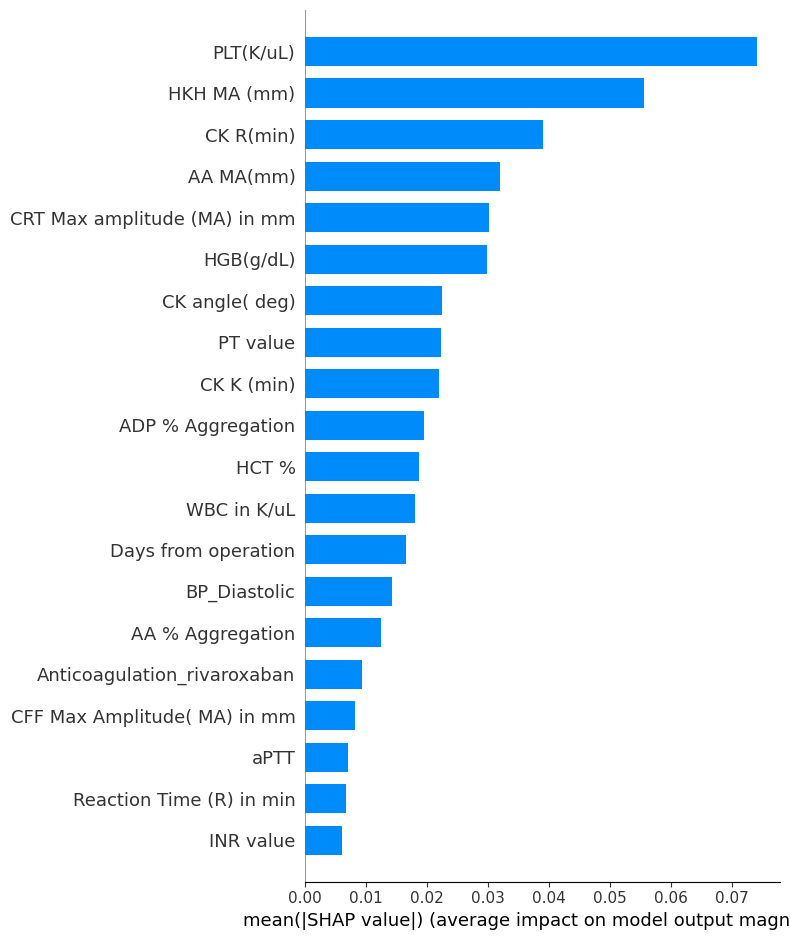

In [391]:
# Plot SHAP summary plot
shap.summary_plot(shap_values_TEG2, TEG2_train, plot_type="bar", show= False)

In [392]:
#!jupyter nbconvert --to script steps.ipynb

# Predict thrombotic event

Import dummy data to try predict their thrombotic event

In [393]:
# Imports excell with patients data
data_path = "./testData/dummy_patient.xlsx"

# Read the uploaded Excel file into a Pandas DataFrame
xls = pd.ExcelFile(data_path, engine="openpyxl")

sheet_names = ['Baseline', 'TEG Values']  # Replace with your sheet names

# Access each sheet's data using the sheet name as the key
baseline_df = pd.read_excel(xls, sheet_names[0])
tegValues_df = pd.read_excel(xls, sheet_names[1])

Getting a new boundaries file because the last one was edited

In [394]:
# Define the filename
filename = 'data_boundaries.json'

# Create the full file path by joining the base directory and filename
file_path = os.path.join(base_directory, 'data', filename)

with open(file_path, 'r') as json_file:
    boundaries = json.load(json_file)
boundaries

{'EGFR (mL/min/1.73m2)': {'>60': 60},
 'Reaction Time (R) in min': {'>17': 18},
 'HKH MA (mm)': {'<42': 40, '>71': 75},
 'ActF MA (mm)': {'>30': 35, '<2': 0},
 'ADP MA (mm)': {'<10': 5, '>72': 77},
 'AA MA(mm)': {'<8': 5},
 'CK R(min)': {'>17': 20},
 'CK K (min)': {'<': '>', '>5': 8},
 'CK angle( deg)': {'<39': 35},
 'CK MA (mm)': {'<40': 35, '>75': 80},
 'CRT MA(mm)': {'<40': 35, '>75': 80},
 'CRT Max amplitude (MA) in mm': {'<40': 35, '>75': 80},
 'CKH R (min)': {'>17': 20},
 'CFF MA(mm)': {'>52': 55, '<4': 0},
 'CFF Max Amplitude( MA) in mm': {'>52': 55, '<4': 0},
 'aPTT': {'>150': 160}}

All of the code from above was copied and paseted to the functions file

In [395]:
from functions import transform_data

In [396]:
# Transform data in the same way the last one was transformed
clean_baseline_patient_df, clean_TEG_patient_df, patient_tegValues = transform_data(baseline_df, tegValues_df, boundaries, timepoints, training = False)

0                      Baseline
1    Post Op day 1 (4-36 hours)
2                         1M PO
Name: Visit Timepoint, dtype: object
0     0
1     1
2    30
Name: Days from operation, dtype: object
This needs to be more rubst
orignally suggested to fill with unknown. Need to figure out how to deal with empty. Fix from category order
New loop


Make sure that the columns in the current database and the columns used to train the model

In [397]:
def check_column_names(df, model_column):
    """
    model_column (list) with column names originally used in model
    """
    
    # Ensure all columns in teg_columns exist in clean_TEG_df
    for column in model_column:
        if column not in df.columns:
            # If the column is missing, add an empty column
            df[column] = pd.Series(dtype=float)

    # Drop columns in clean_TEG_df that are not in teg_columns
    new_df = df[model_column]

    return new_df

Make sure that the columns that are beeing uploaded after they are processed are the same as the columns used to train the model

In [398]:
patient_TEG1_df = check_column_names(clean_TEG_patient_df, teg1_columns)
patient_TEG2_df = check_column_names(clean_TEG_patient_df, teg2_columns)
patient_baseline_df = check_column_names(clean_baseline_patient_df, baseline_columns)


In [399]:

patient_baseline_columns = list(patient_baseline_df.columns)
# Convert lists to sets for easy comparison
baseline_set = set(baseline_columns)
patient_baseline_set = set(patient_baseline_columns)

# Check for columns present in baseline_columns but not in patient_baseline_columns
missing_in_patient_baseline = baseline_set - patient_baseline_set
missing_in_patient_baseline

set()

In [400]:
# Separate features (X) and target (y)
def predict(df, columns_to_drop, best_pipeline):

    for column in columns_to_drop:
        if column in df.columns:
            df.drop(column, axis=1, inplace=True)

    # Make predictions on the test data
    y_pred = best_pipeline.predict(df)

    return y_pred  

In [401]:
baseline_pred = predict(patient_baseline_df, ['Record ID','Events'], best_model_baseline)
baseline_pred

/var/folders/fx/l7m2ftt15p3fzw6vl0894hmh0000gn/T/ipykernel_17828/3518684478.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fx/l7m2ftt15p3fzw6vl0894hmh0000gn/T/ipykernel_17828/3518684478.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([0.0575355], dtype=float32)

In [402]:
TEG1_pred = predict(patient_TEG1_df, ['Record ID','Events'], best_model_TEG1)
TEG1_pred

/var/folders/fx/l7m2ftt15p3fzw6vl0894hmh0000gn/T/ipykernel_17828/3518684478.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fx/l7m2ftt15p3fzw6vl0894hmh0000gn/T/ipykernel_17828/3518684478.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([-0.06713684,  0.10034271, -0.13346033], dtype=float32)

In [403]:
TEG2_pred = predict(patient_TEG2_df, ['Record ID','Events'], best_model_TEG2)
TEG2_pred

/var/folders/fx/l7m2ftt15p3fzw6vl0894hmh0000gn/T/ipykernel_17828/3518684478.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/fx/l7m2ftt15p3fzw6vl0894hmh0000gn/T/ipykernel_17828/3518684478.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([-0.0446545 ,  0.22148056, -0.02046016], dtype=float32)

In [404]:
def iterate_importance(df, best_pipeline):
    total_df = pd.DataFrame()

    # Iterate through all rows in the DataFrame
    for index, row in df.iterrows():
        # Assuming row is a pandas Series containing feature values for a specific row
        # You may need to adjust this depending on the structure of your DataFrame

        # Convert the row to a DataFrame with a single row
        single_row_df = pd.DataFrame([row])

        # Calculate shap_values for the current row
        importance_df, shap_values = feature_importance(best_pipeline, single_row_df)

        # Add the shap_values to new columns in the total_df DataFrame
        total_df = pd.concat([total_df, importance_df.add_prefix(f'shap_value_{index}_')], axis=1)

    return total_df


In [405]:
baseline_shap_values_list = iterate_importance(patient_baseline_df, best_model_baseline)
baseline_shap_values_list


/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[15:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/ana

,shap_value_0_Feature,shap_value_0_Importance
33,Artery affected_internal iliac,0.081424
22,ABI Right,0.058132
23,ABI left,0.044570
0,Age,0.044117
21,Rutherford Score,0.038252
9,History of MI,0.026422
18,EGFR (mL/min/1.73m2),0.009286
2,BMI,0.007693
14,Hx of DVT,0.006251
1,White,0.005599


In [406]:
TEG1_shap_values_list = iterate_importance(patient_TEG1_df, best_model_TEG1)
TEG1_shap_values_list

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning:

[15:54:41] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/anaconda3/envs/Capstone2023/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/opt/ana

,shap_value_0_Feature,shap_value_0_Importance,shap_value_1_Feature,shap_value_1_Importance,shap_value_2_Feature,shap_value_2_Importance
31,BP_Diastolic,0.057338,BP_Diastolic,0.040371,BP_Diastolic,0.040371
20,CFF FLEV(mg/dL),0.053992,CFF FLEV(mg/dL),0.053992,CFF FLEV(mg/dL),0.040776
13,CK R(min),0.042525,CK R(min),0.042525,CK R(min),0.004902
11,AA % Aggregation,0.040203,AA % Aggregation,0.040203,AA % Aggregation,0.021456
17,CRT MA(mm),0.035259,CRT MA(mm),0.033268,CRT MA(mm),0.077244
3,CRT Max amplitude (MA) in mm,0.034836,CRT Max amplitude (MA) in mm,0.030576,CRT Max amplitude (MA) in mm,0.001111
12,AA % Inhibition,0.034528,AA % Inhibition,0.034528,AA % Inhibition,0.035636
19,CFF MA(mm),0.034100,CFF MA(mm),0.019743,CFF MA(mm),0.007856
22,INR value,0.028390,INR value,0.025573,INR value,0.025573
28,HCT %,0.025577,HCT %,0.025577,HCT %,0.025337
